In [23]:
# Common imports and settings
import os, sys, re
from pathlib import Path
from IPython.display import Markdown
import pandas as pd
pd.set_option("display.max_rows", None)
import xarray as xr
import dask
from dask.distributed import Client
from dask_gateway import Gateway
from dateutil.parser import parse
from dateutil.relativedelta import relativedelta

# Datacube
import datacube
from datacube.utils.aws import configure_s3_access
import odc.geo.xr                                  # https://github.com/opendatacube/odc-geo
from datacube.utils import masking  # https://github.com/opendatacube/datacube-core/blob/develop/datacube/utils/masking.py
from odc.algo import enum_to_bool                  # https://github.com/opendatacube/odc-tools/blob/develop/libs/algo/odc/algo/_masking.py
from dea_tools.plotting import display_map, rgb    # https://github.com/GeoscienceAustralia/dea-notebooks/tree/develop/Tools

import boto3

# Basic plots
%matplotlib inline
# import matplotlib.pyplot as plt
# plt.rcParams['figure.figsize'] = [12, 8]

# Holoviews
# https://holoviz.org/tutorial/Composing_Plots.html
# https://holoviews.org/user_guide/Composing_Elements.html
import hvplot.pandas
import hvplot.xarray
import panel as pn
import colorcet as cc
import cartopy.crs as ccrs
from datashader import reductions
from holoviews import opts
# hv.extension('bokeh', logo=False)
print("Libraries loaded successfully.")

Libraries loaded successfully.


In [24]:
# EASI defaults
# These are convenience functions so that the notebooks in this repository work in all EASI deployments

# The `git.Repo()` part returns the local directory that easi-notebooks has been cloned into
# If using the `easi-tools` functions from another path, replace `repo` with your local path to `easi-notebooks` directory
try:
    import git
    repo = git.Repo('.', search_parent_directories=True).working_tree_dir    # Path to this cloned local directory
except (ImportError, git.InvalidGitRepositoryError):
    repo = Path.home() / 'easi-notebooks'    # Reasonable default
    if not repo.is_dir():
        raise RuntimeError('To use `easi-tools` please provide the local path to `https://github.com/csiro-easi/easi-notebooks`')
if repo not in sys.path:
    sys.path.append(str(repo))    # Add the local path to `easi-notebooks` to python

from easi_tools import EasiDefaults
from easi_tools import initialize_dask, xarray_object_size, mostcommon_crs, heading
#from easi_tools.load_s2l2a import load_s2l2a_with_offset
print("EASI librariies loaded successfully.")

EASI librariies loaded successfully.


# Dataprep with Dask
Goals:
- query and prep data
- Load in and save data into user scratch or some other spot

In [25]:
# 1. Get EASI Defaults
easi = EasiDefaults()
bucket = easi.scratch

# 2. Get User ID
userid = boto3.client('sts').get_caller_identity()['UserId']

# 3. Define your Project Name and Dataset Name
project_name = "traning_test_project"
dataset_name = "training_dataset_v1.zarr"

# 4. Construct the full S3 Path
# This is where Dask will write the files
s3_path = f"s3://{bucket}/{userid}/{project_name}/{dataset_name}"

print(f"Target Storage Path: {s3_path}")

Successfully found configuration for deployment "csiro"
Target Storage Path: s3://easihub-csiro-user-scratch/AROAWO7MSC2T2SINGSYOQ:csiro-csiro-aad_gre555@csiro.au/traning_test_project/training_dataset_v1.zarr


For stuff like loading in data, we don't need GPUs yet so this should be ok

In [26]:
gateway = Gateway()
options = gateway.cluster_options()

clusters = gateway.list_clusters()
if not clusters:
    print('Creating new cluster...')
    cluster = gateway.new_cluster(cluster_options=options)
else:
    print(f'Connecting to existing cluster: {clusters[0].name}')
    cluster = gateway.connect(clusters[0].name)


#cluster.scale(4)
client = cluster.get_client()

print("Cluster Dashboard:", client.dashboard_link)


Connecting to existing cluster: easihub.a88c7a4ec4ce49bebed7f7e0a76b0a0b
Cluster Dashboard: https://hub.csiro.easi-eo.solutions/services/dask-gateway/clusters/easihub.a88c7a4ec4ce49bebed7f7e0a76b0a0b/status


In [27]:
# from datacube.utils.masking import describe_variable_flags

# # # Print the available flags for the fmask band
# # import pandas as pd

# # # Show all rows and columns
# # pd.set_option("display.max_rows", None)
# # pd.set_option("display.max_columns", None)
# # pd.set_option("display.width", None)
# # pd.set_option("display.max_colwidth", None)

# # # Now print the flags
# # describe_variable_flags(ds.fmask)
dc = datacube.Datacube()
# So workers can access AWS
configure_s3_access(aws_unsigned=False, requester_pays=True, client=client);

In [7]:
# Get the centroid of the coordinates of the default extents
central_lat = sum(easi.latitude)/2
central_lon = sum(easi.longitude)/2
# central_lat = -42.019
# central_lon = 146.615

# Set the buffer to load around the central coordinates
# This is a radial distance for the bbox to actual area so bbox 2x buffer in both dimensions
buffer = 0.8

# Compute the bounding box for the study area
study_area_lat = (central_lat - buffer, central_lat + buffer)
study_area_lon = (central_lon - buffer, central_lon + buffer)

# Data product
products = easi.product('landsat')

# Set the date range to load data over
set_time = easi.time
set_time = (set_time[0], parse(set_time[0]) + relativedelta(years=1))
# set_time = ("2021-01-01", "2021-12-31")

# ------------------------ Measurment choice -----------------
# Selected measurement names (used in this notebook). None` will load all of them
alias = easi.aliases('landsat')
#all_measurements = list(alias.values())
#print(f"{alias.keys()}")

target_keys = ['blue', 'green', 'red', 'nir', 'swir1', 'swir2']


spectral_measurements = [alias[k] for k in target_keys]
#measurements = [alias['red'], alias['green'], alias['blue'], qa_band]
# measurements = [alias[x] for x in ['qa_band', 'red', 'nir']]

# Set the QA band name and mask values
qa_band = alias['qa_band']
qa_mask = easi.qa_mask('landsat')

measurements = spectral_measurements + [qa_band]

# Set the resampling method for the bands
resampling = {qa_band: "nearest", "*": "average"}

# Set the coordinate reference system and output resolution
set_crs = easi.crs('landsat')  # If defined, else None
set_resolution = easi.resolution('landsat')  # If defined, else None
# set_crs = "epsg:3577"
# set_resolution = (-30, 30)

# Set the scene group_by method
group_by = "solar_day"

In [8]:
label_product = 'ga_ls_landcover_class_cyear_3'
label_measurement = 'level3'

dataset = None # clear results from any previous runs
dataset = dc.load(
            product=products,
            x=study_area_lon,
            y=study_area_lat,
            time=set_time,
            measurements=measurements,
            resampling=resampling,
            output_crs=set_crs,
            resolution=set_resolution,
            dask_chunks = {"time":1, "x":2048, "y":2048},
            group_by=group_by,
        )
print(f"dataset size (GiB) {dataset.nbytes / 2**30:.2f}")
# --- NEW: LOAD AND ALIGN LABELS ---

# 1. Load label data broadly using the initial time range (required by dc.load)
labels_broad_ds = dc.load(
    product=label_product,
    x=study_area_lon,
    y=study_area_lat,
    time=set_time, # Must use start/end date format
    measurements=[label_measurement],
    resampling={"*": "nearest"}, # Labels must use nearest neighbor resampling
    output_crs=set_crs,
    resolution=set_resolution,
    dask_chunks = {"time":1, "x":2048, "y":2048}, # Use same I/O chunking
    group_by=group_by,
)

# 2. Align labels onto the exact time dimension of the Landsat input
labels_ds = labels_broad_ds.reindex_like(
    dataset, 
    method='nearest' # Force alignment to nearest composite map time
)

print(f"Label data successfully aligned. Total scenes: {labels_ds.time.size}")


# Identify pixels that are either "valid", "water" or "snow"
cloud_free_mask = masking.make_mask(dataset[qa_band], **qa_mask)
# Separate the bands we want to TRAIN on (RGB)
# Drop the QA band now, we don't feed it to the model.
training_ds = dataset[spectral_measurements]

# Apply Mask: Use , 0 to replace clouds with Black. 
# Default .where() creates NaNs, which break PyTorch.
ds_masked = training_ds.where(cloud_free_mask, 0)


# Landsat is Int16 (0-10,000). Normalize to Float32 (0-1).
ds_norm = ds_masked.astype('float32') / 10000.0

# Convert Dictionary (Dataset) to Block (DataArray)
# This stacks Red/Green/Blue into a new dimension 'band'
ds_final = ds_norm.to_array(dim='band')

# 1. Extract the aligned label array
labels_da = labels_ds[label_measurement]

# Inspect nodata value if present
print("Label attrs:", labels_da.attrs)
print("Label encoding:", labels_da.encoding)

# 2. Map nodata (if any) to 255, but DO NOT apply the Landsat cloud mask
nodata = labels_da.attrs.get("nodata", None)
if nodata is None:
    nodata = labels_da.encoding.get("_FillValue", None)

if nodata is not None:
    labels_clean = labels_da.where(labels_da != nodata, 255)
else:
    labels_clean = labels_da  # assume all values are valid classes

# 3. Convert to final format (Int64 is required for PyTorch class indices)
labels_final = labels_clean.astype("int64")
training_ds_combined = xr.Dataset(
    {
        'features': ds_final,
        'labels': labels_final
    }
)

# Rechunk for Training
ds_final = training_ds_combined.chunk({'time': 1, 'x': 224, 'y': 224})

print("Data Pipeline Ready:")
ds_final

dataset size (GiB) 18.34
Label data successfully aligned. Total scenes: 43
Label attrs: {'units': '1', 'nodata': 255, 'crs': 'EPSG:3577', 'grid_mapping': 'spatial_ref'}
Label encoding: {}
Data Pipeline Ready:


<xarray.Dataset> Size: 48GB
Dimensions:      (time: 43, y: 6441, x: 5469, band: 6)
Coordinates:
  * time         (time) datetime64[ns] 344B 2020-02-08T23:56:31.774346 ... 20...
  * y            (y) float64 52kB -3.922e+06 -3.922e+06 ... -4.115e+06
  * x            (x) float64 44kB 1.272e+06 1.272e+06 ... 1.436e+06 1.436e+06
    spatial_ref  int32 4B 3577
  * band         (band) object 48B 'nbart_blue' 'nbart_green' ... 'nbart_swir_2'
Data variables:
    features     (band, time, y, x) float32 36GB dask.array<chunksize=(1, 1, 224, 224), meta=np.ndarray>
    labels       (time, y, x) int64 12GB dask.array<chunksize=(1, 224, 224), meta=np.ndarray>

In [10]:
client.restart()

In [ ]:
# Fixed an error in the Zar encoding, time already has units or something i guess?
ds_final.time.attrs.pop('units', None)

task = ds_final.to_zarr(s3_path, mode='w', consolidated=True, compute=False)

print("Graph built. Submitting to cluster...")

dask.compute(task)



/env/lib/python3.12/site-packages/zarr/api/asynchronous.py:233: ZarrUserWarning: Consolidated metadata is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  warnings.warn(


Graph built. Submitting to cluster...


/env/lib/python3.12/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 119.30 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


In [32]:
# Check
ds = xr.open_dataset(s3_path, engine='zarr')
print(ds)

<xarray.Dataset> Size: 48GB
Dimensions:      (band: 6, time: 43, y: 6441, x: 5469)
Coordinates:
  * band         (band) object 48B 'nbart_blue' 'nbart_green' ... 'nbart_swir_2'
    spatial_ref  int32 4B ...
  * time         (time) datetime64[ns] 344B 2020-02-08T23:56:31.774346 ... 20...
  * x            (x) float64 44kB 1.272e+06 1.272e+06 ... 1.436e+06 1.436e+06
  * y            (y) float64 52kB -3.922e+06 -3.922e+06 ... -4.115e+06
Data variables:
    features     (band, time, y, x) float32 36GB ...
    labels       (time, y, x) int64 12GB ...


⏳ Verifying Saved Data (Automated Search)...
Features: ('band', 'time', 'y', 'x') (6, 43, 6441, 5469)
Labels:   ('time', 'y', 'x') (43, 6441, 5469)
time= 0, valid_frac=1.000, unique=[111 112 215 216 220 255]
time= 1, valid_frac=1.000, unique=[111 112 215 216 220 255]
time= 2, valid_frac=1.000, unique=[111 112 215 216 220 255]
time= 3, valid_frac=1.000, unique=[111 112 215 216 220 255]
time= 4, valid_frac=1.000, unique=[111 112 215 216 220 255]
time= 5, valid_frac=1.000, unique=[111 112 215 216 220 255]
time= 6, valid_frac=1.000, unique=[111 112 215 216 220 255]
time= 7, valid_frac=1.000, unique=[111 112 215 216 220 255]
time= 8, valid_frac=1.000, unique=[111 112 215 216 220 255]
time= 9, valid_frac=1.000, unique=[111 112 215 216 220 255]
Checking time index 0... Cloudy/Empty. Skipping.
Checking time index 4... Valid Data Found! (Max: 0.72)


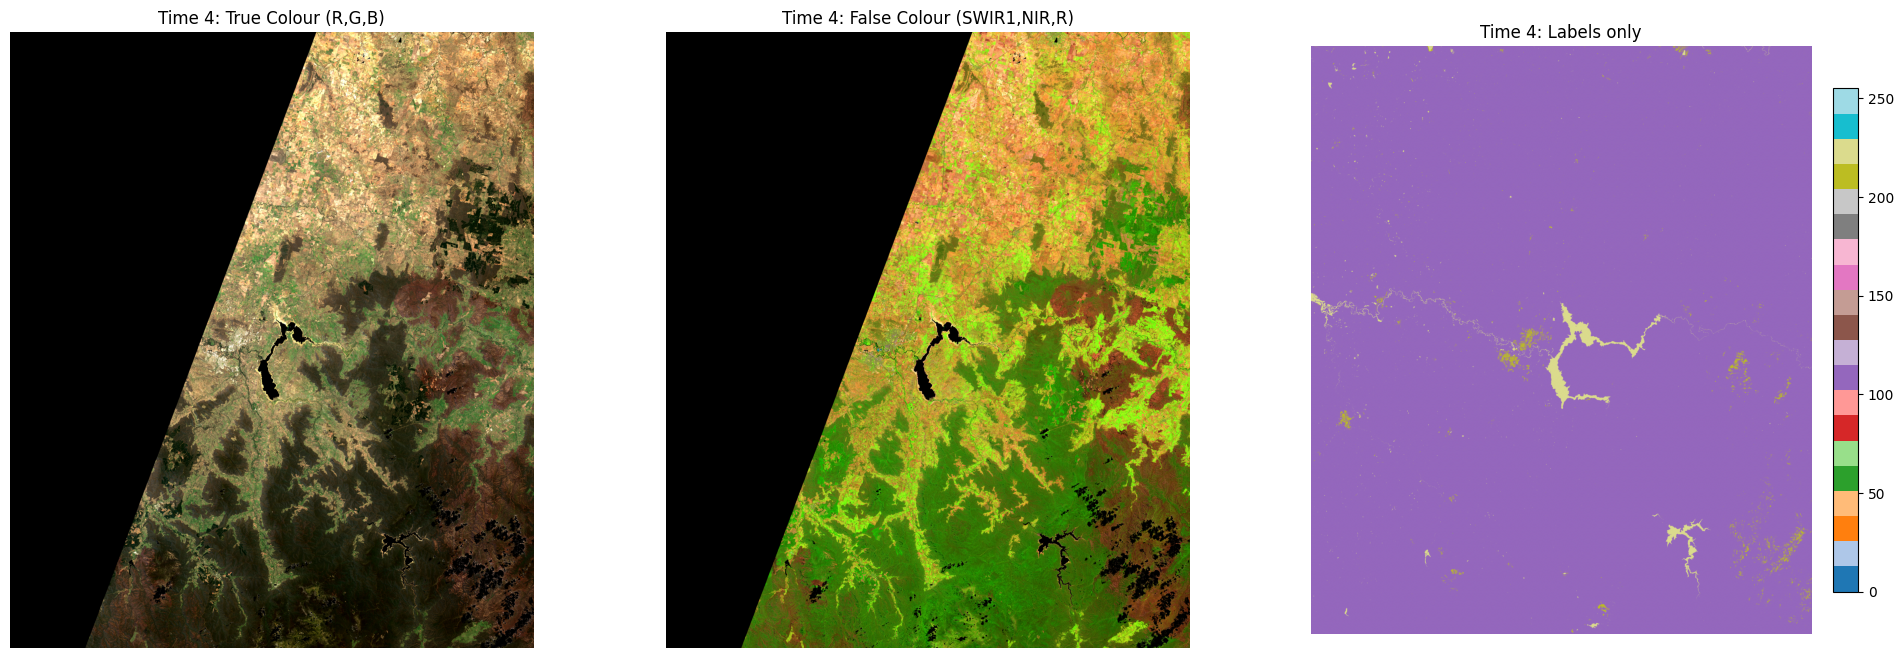

In [34]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

print("⏳ Verifying Saved Data (Automated Search)...")

# Open via xarray; this handles s3:// with fsspec behind the scenes
ds = xr.open_dataset(s3_path, engine='zarr')  # s3_path is your s3://... string

features = ds['features']         # dims: ('band', 'time', 'y', 'x')
labels   = ds['labels']           # dims: ('time', 'y', 'x')

print("Features:", features.dims, features.shape)
print("Labels:  ", labels.dims, labels.shape)

# Optional quick label sanity check
for t in range(0, min(labels.sizes['time'], 10)):
    lbl = labels.isel(time=t).values
    valid_frac = (lbl != 255).mean()
    uniques = np.unique(lbl)
    print(f"time={t:2d}, valid_frac={valid_frac:.3f}, unique={uniques[:10]}")

rgb_bands = ['nbart_red', 'nbart_green', 'nbart_blue']
false_color_bands = ['nbart_swir_1', 'nbart_nir', 'nbart_red']

def get_contrast_stretched_image(sample_block, band_names):
    # sample_block: DataArray (band, y, x)
    subset = sample_block.sel(band=band_names).transpose('y', 'x', 'band').values
    subset = subset.astype('float32')

    valid_data = subset[subset > 0]
    if valid_data.size == 0:
        return subset
    p_low, p_high = np.percentile(valid_data, (2, 98))
    if p_high == p_low:
        return subset
    img_stretched = (subset - p_low) / (p_high - p_low)
    return np.clip(img_stretched, 0, 1)

# --- SEARCH LOOP ---
for t in range(0, min(features.sizes['time'], 40), 4):
    print(f"Checking time index {t}...", end=" ")

    # features: (band, time, y, x) → slice by time to get (band, y, x)
    sample_feat = features.isel(time=t).compute()
    sample_lbl  = labels.isel(time=t).compute()

    # brightness check on red band
    if sample_feat.sel(band=rgb_bands[0]).max() < 0.5:
        print("Cloudy/Empty. Skipping.")
        continue

    # ensure some valid labels
    if (sample_lbl.values != 255).mean() == 0.0:
        print("No valid labels at this time. Skipping.")
        continue

    print(f"Valid Data Found! (Max: {sample_feat.max().item():.2f})")

    rgb_img   = get_contrast_stretched_image(sample_feat, rgb_bands)
    false_img = get_contrast_stretched_image(sample_feat, false_color_bands)

    plt.figure(figsize=(24, 8))

    # 1. True colour (RGB)
    plt.subplot(1, 3, 1)
    plt.imshow(rgb_img)
    plt.title(f"Time {t}: True Colour (R,G,B)")
    plt.axis('off')
    
    # 2. False colour (SWIR1, NIR, Red)
    plt.subplot(1, 3, 2)
    plt.imshow(false_img)
    plt.title(f"Time {t}: False Colour (SWIR1,NIR,R)")
    plt.axis('off')

    # 3. Labels
    plt.subplot(1, 3, 3)
    lbl_np = sample_lbl.values
    mask = np.ma.masked_where(lbl_np == 255, lbl_np)
    im3 = plt.imshow(mask, vmin=0, vmax=255, cmap='tab20')
    plt.title(f"Time {t}: Labels only")
    plt.axis('off')
    plt.colorbar(im3, fraction=0.046, pad=0.04)

    plt.show()
    break


In [41]:
client.close()
cluster.shutdown()